# REGIME CHANGE
**MUSTAFA S EISA** \ 14 APRIL 2017

This package contains tools for the local, semi-parametric detection of regime changes in a bivariate time series setting. Regime changes can be defined with respect to a given bivariate mapping (eg. correlation, tracking error) and a kernel weighting parameter that controls the fidelity of the estimator to local changes.

In [35]:
import regimechange as rg

The `METRICS` dictionary contains a set of pre-defined metric functions that define a state change.

In [36]:
print('Pre-defined metrics include: ' + ', '.join(rg.METRICS.keys()) + '.')

Pre-defined metrics include: excess return, excess volatility, correlation, tracking error.


The `KERNELS` dictionary contains a set of pre-defined kernels that control sensitivity to local information.

In [37]:
print('Pre-defined kernels include: ' + ', '.join(rg.KERNELS.keys()) + '.')

Pre-defined kernels include: hyperbolic, gaussian, triangular, uniform.


The Gaussian and Uniform (aka K-nearest-neighbor) kernels are well known. We provide the other two for completeness. The hyperbolic kernel $\kappa_h:\mathbb{R}^n\times\mathbb{R}^n \mapsto \mathbb{R}_{++}$ with bandwidth $b$ is of the form

$$\kappa_h(x, y) = \left(\frac{1}{1 + \|x - y\|}\right)^{b}$$

while the triangular kernel $\kappa_t:\mathbb{R}^n\times\mathbb{R}^n \mapsto \mathbb{R}_{++}$ with bandwidth $b$ is of the form

$$\kappa_t(x, y) = \left(1 - \frac{\|x - y\|}{b} \right)_+$$

### Usage

We demonstrate the use of this package and its effectiveness in the following examples.

In [38]:
from matplotlib import pyplot as plt
import regimechange as rg
import numpy as np

plt.style.use('ggplot')
%matplotlib inline

Consider a discrete regime change that occurs in with respect to the Pearson correlation coefficient. Specifically, we'll generate data where one time series is almost perfectly correlated with the other and then, at day 68, the correlation flips signs.

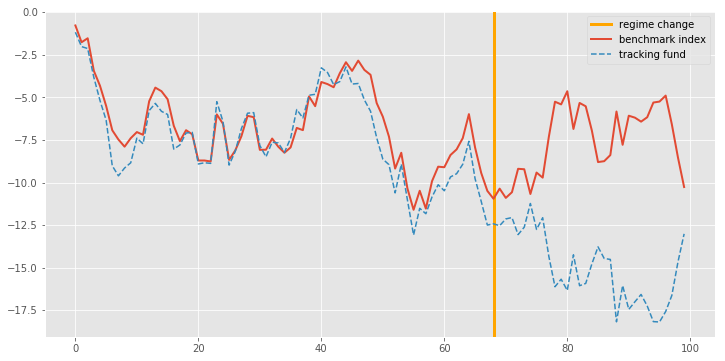

In [62]:
benchmark = np.random.normal(size=(100,1)) # some benchmark index
tracking = benchmark.copy() + .5*np.random.normal(size=(100,1)) # fund tracking benchmark
tracking[68:] = -1*tracking[68:] # flip relationship at day 68

plt.figure(figsize=(12, 6))
plt.axvline(x=68, color = 'orange', label='regime change', linewidth=3)
plt.plot(np.cumsum(benchmark), label='benchmark index', linewidth=2)
plt.plot(np.cumsum(tracking), label='tracking fund', linestyle='--')
plt.legend()
plt.show()

We can estimate when this regime change occurred using the `kernel_split` method:

In [63]:
data = np.hstack((benchmark, tracking))
rg.kernel_split(
    time_series=data,
    metric=rg.METRICS['correlation'],
    kernel=rg.KERNELS['uniform'],
    bandwidth=25,
    pad=1
)

# 68

(68, 1.8800332588540651)

Suppose there are multiple correlation regime changes.

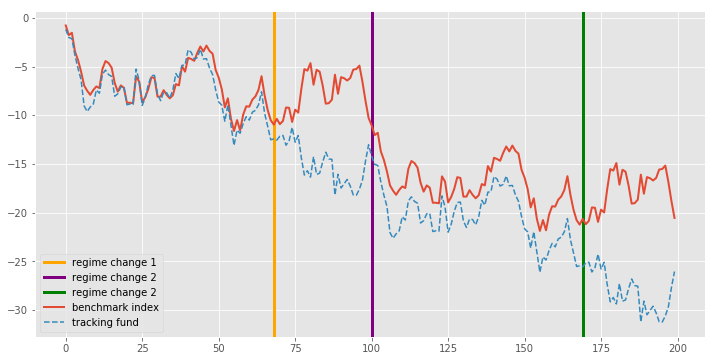

In [64]:
data = np.vstack((data, data))

plt.figure(figsize=(12, 6))
plt.axvline(x=68, color = 'orange', label='regime change 1', linewidth=3)
plt.axvline(x=100, color = 'purple', label='regime change 2', linewidth=3)
plt.axvline(x=169, color = 'green', label='regime change 2', linewidth=3)
plt.plot(np.cumsum(data[:, 0]), label='benchmark index', linewidth=2)
plt.plot(np.cumsum(data[:, 1]), label='tracking fund', linestyle='--')
plt.legend()
plt.show()

For detecting these several regime changes, we can turn to the `successive_split` method which implements some regime change mechanism (like `kernel_split`) recursively. For this, we'll need a univariate function that outputs the location of a regime change such as the following.

In [70]:
ks = lambda time_series: rg.kernel_split(
    time_series,
    metric=rg.METRICS['correlation'],
    kernel=rg.KERNELS['triangular'],
    bandwidth=25,
    pad=1
)

Then we can run the `successive_split` method, specifying a hypothesis number of splits in the argument `num_splits`. The `successive_split` method works by identifying a regime change, dividing the time series into two partitions, then re-performing detection recursively on each partition. By this logic, $\mathcal{O}\left(2^{\lceil \log_2(n) \rceil}\right)$ regime changes will be computed and the top $n$ most drastic estimated regime changes will be returned, where $n$ represents `num_splits`. Better results are thus obtained by choosing a conservatively high `num_splits` so that enough exploration takes place before the results are ranked.

For this case, we'll set `num_splits` to 5, an upper bound for how many regimes we expect to have in the data.

In [71]:
rg.successive_split(
    time_series=data,
    kernel_splitter=ks,
    num_splits=5
)

[(168, 1.9005015889472829),
 (68, 1.9005015889472827),
 (100, 1.8256333481430742),
 (31, 0.095901802064368602),
 (131, 0.095901802064368602)]

As can be seen, the three regime changes are identified and ranked at the top with large values while the latter two returned items have significantly lower values, signifying that a regime change likely did not occur at those times.

Another example is with the metric tracking error. We'll generate data where one time series tracks the other well then suddenly tracks poorly starting on day 40.

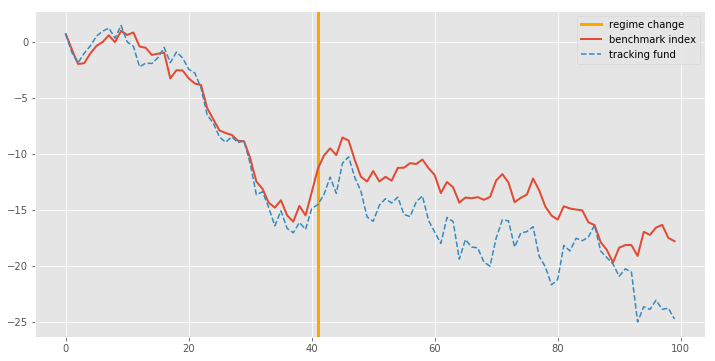

In [92]:
benchmark = np.random.normal(size=(100,1)) # some benchmark index
tracking = benchmark.copy() + .5*np.random.normal(size=(100,1)) # fund tracking benchmark
tracking[40:] = tracking[40:] + np.random.normal(size=(60,1)) # tracking error blows up at day 40

plt.figure(figsize=(12, 6))
plt.axvline(x=41, color = 'orange', label='regime change', linewidth=3)
plt.plot(np.cumsum(benchmark), label='benchmark index', linewidth=2)
plt.plot(np.cumsum(tracking), label='tracking fund', linestyle='--')
plt.legend()
plt.show()

We can again estimate when this regime change occurred using the `kernel_split` method:

In [93]:
data = np.hstack((benchmark, tracking))
rg.kernel_split(
    time_series=data,
    metric=rg.METRICS['tracking error'],
    kernel=rg.KERNELS['gaussian'],
    bandwidth=10
)

# 41

(41, 0.58183784971618535)

### Speed Test

In [75]:
%timeit rg.kernel_split(\
    time_series=data,\
    metric=rg.METRICS['tracking error'],\
    kernel=rg.KERNELS['hyperbolic'],\
    bandwidth=10,\
    pad=1\
)

100 loops, best of 3: 16.6 ms per loop
